In [1]:
# 2021 / 07 / 07. Dongil Choi
# Reference --> https://notebook.community/jcrist/pydy/examples/differential_drive/Differential%20Drive

In [2]:
from sympy import symbols
from sympy import simplify
from sympy.physics.mechanics import *
from sympy import sin, cos, symbols, Matrix, solve
from sympy.physics.vector import init_vprinting
init_vprinting()

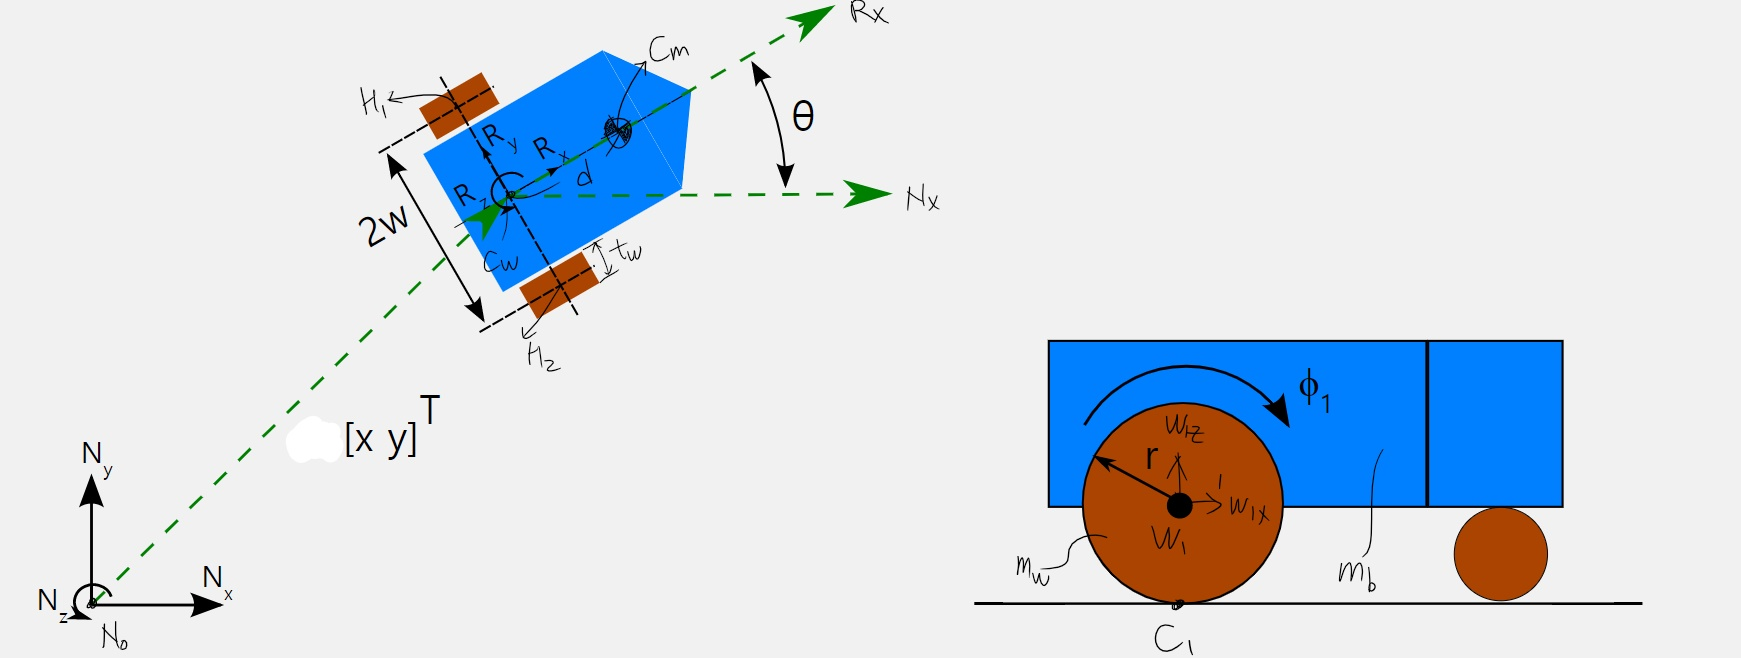

In [3]:
from IPython.display import Image
Image('figure/diff_drive_fig_inked.jpg', width=800)

In [4]:
#Newtonian reference frame
N = ReferenceFrame('N')
# Define a world coordinate origin
No = Point('No')
No.set_vel(N, 0)
# Rotation about N.z
theta = dynamicsymbols('theta')
# Coordinates of robot in World Frame
x, y = dynamicsymbols('x, y')
# Angular displacement of wheel
phi1, phi2 = dynamicsymbols('phi_1, phi_2')          

In [5]:
# Create q and dq vectors
q = Matrix([x, y, theta, phi1, phi2])
dq = q.diff()
q, dq

⎛⎡x ⎤  ⎡ẋ ⎤⎞
⎜⎢  ⎥  ⎢  ⎥⎟
⎜⎢y ⎥  ⎢ẏ ⎥⎟
⎜⎢  ⎥  ⎢  ⎥⎟
⎜⎢θ ⎥, ⎢θ̇ ⎥⎟
⎜⎢  ⎥  ⎢  ⎥⎟
⎜⎢φ₁⎥  ⎢φ₁̇⎥⎟
⎜⎢  ⎥  ⎢  ⎥⎟
⎝⎣φ₂⎦  ⎣φ₂̇⎦⎠

In [6]:
# Constants for the wheels
r = symbols('r')                                     # Radius of wheel
m_w = symbols('m_w')                                 # Mass of the wheel
t_w = symbols('t_w')                                 # Thickness of the wheel

# Constants for the Robot Body
w = symbols('w')                                     # 2*w is the width of the wheel base
d = symbols('d')                                     # Distance between axle and center of mass
m_b = symbols('m_b')                                 # Mass of the body
Ixx, Iyy, Izz = symbols('Ixx, Iyy, Izz')             # Moments of inertia of body

In [7]:
# Robot Reference Frame
R = N.orientnew('R', 'Axis', [theta, N.z])

# Center of wheel base
Cw = No.locatenew('Cw', x*N.x + y*N.y)

# Set the velocity of point Cw
Cw.set_vel(N, x.diff()*N.x + y.diff()*N.y)

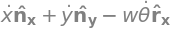

In [8]:
# Points at wheel hubs
H1 = Cw.locatenew('H1', -w*R.y)
H2 = Cw.locatenew('H2', w*R.y)

# Set the velocity of points H1 and H2
H1.v2pt_theory(Cw, N, R)
H2.v2pt_theory(Cw, N, R)

In [9]:
# Create reference frames for wheels 1 and 2
W1 = R.orientnew('W1', 'Axis', [phi1, R.y])
W2 = R.orientnew('W2', 'Axis', [phi2, R.y])

In [10]:
# Calculate inertia of the wheel
Iw = inertia(R, m_w*(3*r**2 + t_w**2)/12, m_w*r**2/2, m_w*(3*r**2 + t_w**2)/12) # Inertia Dyadic

# Create rigid bodies for wheels
Wheel1 = RigidBody('Wheel1', H1, W1, m_w, (Iw, H1))
Wheel2 = RigidBody('Wheel2', H2, W2, m_w, (Iw, H2))

In [11]:
# Calculate inertia of body
Ib = inertia(R, Ixx, Iyy, Izz)

# Center of mass of body
Cm = Cw.locatenew('Cm', d*R.x)
Cm.v2pt_theory(Cw, N, R)

# Create a rigid body object for body
Body = RigidBody('Body', Cm, R, m_b, (Ib, Cm))

In [12]:
# Create two points, where the wheels contact the ground
C1 = H1.locatenew('C1', -r*R.z)
C2 = H2.locatenew('C2', -r*R.z)
# Calculate velocity of points
C1.v2pt_theory(H1, N, W1)
C2.v2pt_theory(H2, N, W2);

In [13]:
# Express the velocity of points in the inertial frame
con1 = C1.vel(N).express(N).args[0][0]
con2 = C2.vel(N).express(N).args[0][0]
# Create a matrix of constraints
constraints = con1.col_join(con2)
constraints

⎡(-r⋅φ₁̇ + w⋅θ̇)⋅cos(θ) + ẋ⎤
⎢                        ⎥
⎢(-r⋅φ₁̇ + w⋅θ̇)⋅sin(θ) + ẏ⎥
⎢                        ⎥
⎢           0            ⎥
⎢                        ⎥
⎢(-r⋅φ₂̇ - w⋅θ̇)⋅cos(θ) + ẋ⎥
⎢                        ⎥
⎢(-r⋅φ₂̇ - w⋅θ̇)⋅sin(θ) + ẏ⎥
⎢                        ⎥
⎣           0            ⎦

In [14]:
# Solve for dx, dy, and dtheta in terms of dphi1 and dphi2
sol = solve(constraints, dq[:3])

# Split the resulting dict into a rhs and lhs, that are equivalent
sol_rhs = Matrix(list(sol.values()))
sol_lhs = Matrix(list(sol.keys()))

sol_rhs, sol_lhs

⎛⎡r⋅cos(θ)⋅φ₁̇   r⋅cos(θ)⋅φ₂̇⎤     ⎞
⎜⎢─────────── + ───────────⎥     ⎟
⎜⎢     2             2     ⎥     ⎟
⎜⎢                         ⎥  ⎡ẋ⎤⎟
⎜⎢r⋅sin(θ)⋅φ₁̇   r⋅sin(θ)⋅φ₂̇⎥  ⎢ ⎥⎟
⎜⎢─────────── + ───────────⎥, ⎢ẏ⎥⎟
⎜⎢     2             2     ⎥  ⎢ ⎥⎟
⎜⎢                         ⎥  ⎣θ̇⎦⎟
⎜⎢       r⋅φ₁̇   r⋅φ₂̇       ⎥     ⎟
⎜⎢       ──── - ────       ⎥     ⎟
⎝⎣       2⋅w    2⋅w        ⎦     ⎠

In [15]:
# Since sol_rhs = sol_lhs --> sol_rhs - sol_lhs = 0
# This forms the basis of our constraint matrix.
# Combining, and solving for a linear representation:
c = (sol_rhs - sol_lhs).jacobian(dq[:5])
c

⎡            r⋅cos(θ)  r⋅cos(θ)⎤
⎢-1  0   0   ────────  ────────⎥
⎢               2         2    ⎥
⎢                              ⎥
⎢            r⋅sin(θ)  r⋅sin(θ)⎥
⎢0   -1  0   ────────  ────────⎥
⎢               2         2    ⎥
⎢                              ⎥
⎢               r        -r    ⎥
⎢0   0   -1    ───       ───   ⎥
⎣              2⋅w       2⋅w   ⎦

In [16]:
# Constraint Equations
coneqs = (c*dq)
coneqs

⎡r⋅cos(θ)⋅φ₁̇   r⋅cos(θ)⋅φ₂̇    ⎤
⎢─────────── + ─────────── - ẋ⎥
⎢     2             2         ⎥
⎢                             ⎥
⎢r⋅sin(θ)⋅φ₁̇   r⋅sin(θ)⋅φ₂̇    ⎥
⎢─────────── + ─────────── - ẏ⎥
⎢     2             2         ⎥
⎢                             ⎥
⎢       r⋅φ₁̇   r⋅φ₂̇           ⎥
⎢       ──── - ──── - θ̇       ⎥
⎣       2⋅w    2⋅w            ⎦

In [17]:
# Define forces on system:
T1, T2 = symbols('tau_1, tau_2')              # Torques from the wheels
fl = [(H1, r*T1*R.x),
      (H2, r*T2*R.x)]

In [18]:
fl

[(H1, r*tau_1*R.x), (H2, r*tau_2*R.x)]

In [19]:
Lag = Lagrangian(N, Wheel1, Wheel2, Body)

In [20]:
lm = LagrangesMethod(Lag, q[:3], nonhol_coneqs=coneqs, forcelist=fl, frame=N)

In [21]:
le = lm.form_lagranges_equations()
simplify(le)

⎡                                             2                               
⎢             -d⋅m_b⋅sin(θ)⋅θ̈ - d⋅m_b⋅cos(θ)⋅θ̇  + m_b⋅ẍ + 2⋅m_w⋅ẍ - r⋅τ₁⋅c
⎢                                                                             
⎢                            2                                                
⎢            - d⋅m_b⋅sin(θ)⋅θ̇  + d⋅m_b⋅cos(θ)⋅θ̈ + m_b⋅ÿ + 2⋅m_w⋅ÿ - r⋅τ₁⋅s
⎢                                                                             
⎢                                                          2            2     
⎢         2                                           m_w⋅r ⋅θ̈   m_w⋅t_w ⋅θ̈ 
⎢Izz⋅θ̈ + d ⋅m_b⋅θ̈ - d⋅m_b⋅sin(θ)⋅ẍ + d⋅m_b⋅cos(θ)⋅ÿ + ──────── + ─────────
⎣                                                        2           6        

                                   ⎤
os(θ) - r⋅τ₂⋅cos(θ) - lam₁             ⎥
                                   ⎥
                                   ⎥
in(θ) - r⋅τ₂⋅sin(θ) - lam₂             ⎥
                

In [22]:
# Simulation
from sympy import lambdify, Dummy
from sympy.physics.mechanics import msubs
from scipy import array, hstack, linspace, ones
from scipy import random, interp, vstack
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
# Solve for the rhs:
rhs = lm.rhs()

# Substitute in d = 0
rhs = msubs(rhs, {d: 0})

In [24]:
# Create dynamic symbols for current and voltage
i_1, i_2 = dynamicsymbols('i_1, i_2')        # Currents through motor 1 and 2
V_1, V_2 = symbols('V_1, V_2')               # Voltages across the motor terminals

# Define some motor constants.
# Assuming motor 1 and 2 are the same:
R = symbols('R')                             # Coil resistance
L = symbols('L')                             # Coil inductance
K1, K2 = symbols('K1, K2')                   # Motor constant

# Define the motor dynamics
di = Matrix([[-K1/L*phi1.diff() - R/L*i_1 + V_1/L],
             [-K2/L*phi2.diff() - R/L*i_2 + V_2/L]])

In [25]:
# Define consts:
params = [Izz,  t_w,  m_w,    r,  m_b,   w,    R,      L,   K1,  K2]
values = [  5, 0.15,  2.0, 0.15, 50.0, 0.6, 0.05, 0.0001,  1.0, 1.0]       # Values of constants

# Create a list of dynamic symbols for simulation
dynamics = q.T.tolist()[0] + dq.T.tolist()[0] + lm.lam_vec.T.tolist()[0] + [i_1, i_2]

# Set the inputs to be the motor voltages
inputs = [V_1, V_2]

# Add the motor model to the rhs equations
aug_rhs = rhs.col_join(di)

# Substitute in K*i for T in the rhs equations
aug_rhs = aug_rhs.subs({T1: K1*i_1, T2: K2*i_2})

In [26]:
dynamics

In [27]:
# Create a list of dynamic symbols for simulation
dummys = [Dummy() for i in dynamics]
dummydict = dict(zip(dynamics, dummys))
# Sub in the dummy symbols
rhs_dummy = msubs(aug_rhs, dummydict)
# Lambdify function
rhs_func = lambdify(dummys + inputs + params, rhs_dummy, modules='numpy')

In [28]:
# Create a function in the required format for odeint
def right_hand_side(x, t, ts, us, values):
    """Calculate the rhs of the integral, at
    time t, state x.
    ts, us are used to get the current input
    values are constants in the integral"""
    
    # Interp is needed to get u for timestep
    u1 = interp(t, ts, us[:,0])
    u2 = interp(t, ts, us[:,1])
    
    arguments = hstack((x, u1, u2, values))
    
    # Need call to array and reshape, as odeint
    # requires state vector to be 1d
    dx = array(rhs_func(*arguments))
    return dx.reshape(dx.size)

In [29]:
ts = linspace(0, 30, 3000)
us = vstack((24*ones(len(ts)), 20*ones(len(ts)))).T
# Run the simulation
x0 = [0,] * 15                         # Start out at origin, unmoving
xs = odeint(right_hand_side, x0, ts, args=(ts, us, values))

plt.plot(xs[:,5], xs[:,6])
plt.title('Robot Position')
plt.xlabel('x (m)')
plt.ylabel('y (m)');

<ipython-input-29-1c89cc602123>:1: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  ts = linspace(0, 30, 3000)
<ipython-input-29-1c89cc602123>:2: DeprecationWarning: scipy.ones is deprecated and will be removed in SciPy 2.0.0, use numpy.ones instead
  us = vstack((24*ones(len(ts)), 20*ones(len(ts)))).T
<ipython-input-29-1c89cc602123>:2: DeprecationWarning: scipy.vstack is deprecated and will be removed in SciPy 2.0.0, use numpy.vstack instead
  us = vstack((24*ones(len(ts)), 20*ones(len(ts)))).T
<ipython-input-28-69875c133f60>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  u1 = interp(t, ts, us[:,0])
<ipython-input-28-69875c133f60>:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  u2 = interp(t, ts, us[:,1])
<ipython-input-28-69875c133f60>:12: DeprecationWarning: scipy.hstack is deprecated and 

NameError: name 'Derivative' is not defined

In [ ]:
ts = linspace(0, 30, 1000)
us = vstack((24*ones(len(ts)), 20*ones(len(ts)))).T
# Body is twice as heavy, with twice as much rotational inertia
values = [  10, 0.15,  2.0, 0.15, 100.0, 0.6, 0.05, 0.0001,  1.0, 1.0]       # Values of constants
# Run the simulation
x0 = [0,] * 15                         # Start out at origin, unmoving
xs = odeint(right_hand_side, x0, ts, args=(ts, us, values))
plt.plot(xs[:,0], xs[:,1])
plt.title('Robot Position')
plt.xlabel('x (m)')
plt.ylabel('y (m)');

In [ ]:
from IPython.display import Image
Image('figure/3d_inv_pen_fig.PNG', width=600)

In [ ]:
M_c, M_p, M = symbols('M_c M_p M')

In [ ]:
I = Point('I')


In [ ]:
dir()

In [ ]:
help(RigidBody)